In [1]:
import numpy
import torch
import torchvision
import torchflow
from matplotlib import pyplot

In [120]:
# setup
image_size = 32
dataset = torchvision.datasets.CIFAR10(
    root="data", download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

c, h, w = dataset[0][0].shape
n_feat = c * h * w
model = torchflow.model.real_nvp(4, n_feat, 256)
target_dist = torch.distributions.MultivariateNormal(torch.zeros(n_feat), torch.eye(n_feat))
if torch.cuda.is_available():
    model.cuda()
    torchflow.distribution.cuda_(target_dist)
optimizer = torch.optim.Adam(model.parameters())

Files already downloaded and verified


In [122]:
loader = torch.utils.data.DataLoader(
     dataset, batch_size=1024,
     shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

for epoch in range(50):
    sum_loss = 0
    for xs, ys in loader:
        if torch.cuda.is_available():
            xs = xs.cuda()
        n_batch = xs.shape[0]
        zs, log_det_jacobian = model(xs.view(n_batch, n_feat))
        loss = -(target_dist.log_prob(zs).sum() + log_det_jacobian) / n_batch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
    print("epoch: {}, loss: {}".format(epoch, sum_loss / len(loader)))

epoch: 0, loss: 2193.552694515306
epoch: 1, loss: 1066.3753861407845
epoch: 2, loss: 723.0662100655692
epoch: 3, loss: 393.1776453134965
epoch: 4, loss: 474.47671259665975
epoch: 5, loss: 171.29559575294962
epoch: 6, loss: 1151.8571602957588
epoch: 7, loss: 433.7264653419962
epoch: 8, loss: 60.45605787938955
epoch: 9, loss: 30.295467454559947
epoch: 10, loss: 123.90257823710539
epoch: 11, loss: -102.37561159717794
epoch: 12, loss: -9.733983253946109
epoch: 13, loss: -293.1431747747927
epoch: 14, loss: -362.9239589146205
epoch: 15, loss: -226.44262525986653
epoch: 16, loss: -335.6436101173868
epoch: 17, loss: -425.95365314094386
epoch: 18, loss: -574.6532156808036
epoch: 19, loss: -524.0156809359181
epoch: 20, loss: 1323.0392368861608
epoch: 21, loss: 316.5443887515944
epoch: 22, loss: nan
epoch: 23, loss: nan
epoch: 24, loss: nan
epoch: 25, loss: nan
epoch: 26, loss: nan
epoch: 27, loss: nan
epoch: 28, loss: nan
epoch: 29, loss: nan
epoch: 30, loss: nan
epoch: 31, loss: nan
epoch: 32, 

In [96]:
with torch.no_grad():
    zs = target_dist.loc
    ixs, _ = model.inverse(zs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


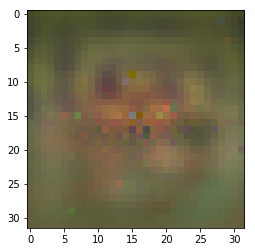

In [97]:
from matplotlib import pyplot
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
stddev = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
def to_img(x):
    xx = (x.view(3, 32, 32).cpu() * stddev) + mean
    return xx.permute(1, 2, 0)
pyplot.imshow(to_img(ixs))

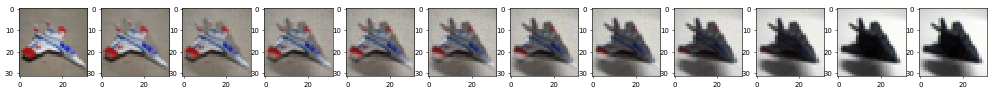

In [121]:
x0 = dataset[29][0].cuda()
x1 = dataset[30][0].cuda()
n = 10
pyplot.figure(figsize=(25, 10), dpi=50)
pyplot.subplot(1, 2 + n, 1)
pyplot.imshow(to_img(x1))
with torch.no_grad():
    z0 = model(x0.view(1, -1))[0]
    z1 = model(x1.view(1, -1))[0]
    xs = []
    for i in range(n):
        zn = (z0 * (i + 1) + z1 * (n - i - 1)) / n
        xn = model.inverse(zn)[0]
        xs.append(xn)
        pyplot.subplot(1, 2 + n, i + 2)
        pyplot.imshow(to_img(xn))

pyplot.subplot(1, 2 + n, n + 2)
ax = pyplot.imshow(to_img(x0))

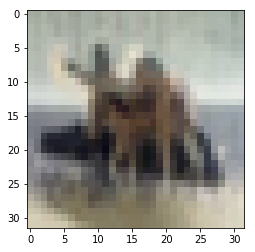

In [117]:
# [(i, dataset[i][1]) for i in range(50)]
pyplot.imshow(to_img((x1 + x0) / 2))

In [88]:
dataset.train_labels[:10]

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]